In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os
from skimage import draw

# Dataset Class Documentation
## DenseNet:
Input: samples x in_channels (RGB) x im Height x im Width

## Logistic Regression
Input: samples x in_channels (RGB) x flattened image 

# DenseNet

## GET CSV and IMAGE

In [166]:
# Directories
csv_dir = "../DATASET/csv"
im_dir = "../DATASET/rgb"

# Get File Names
def get_files(dir):
    return [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]

csv_files = get_files(csv_dir)
im_files = get_files(im_dir)

# Get CSV Dataframes 
def get_csv_df(dir, dir_paths, idx):
    path = os.path.join(dir, dir_paths[idx])
    return pd.read_csv(path)

# _________ TEST CSV _________
# csv_df = get_csv_df(csv_dir, csv_files, 0)
# print(csv_df.head())
# print("Type =", csv_df.dtypes)
# ____________________________

# Get Image Data
def get_im_data(dir, dir_paths, idx):
    path = os.path.join(dir, dir_paths[idx])
    return plt.imread(path)

# _________ TEST IMAGE _________
# img_array = get_im_data(im_dir, im_files, 0)
# plt.imshow(img_array)
# plt.show()
# print("Shape =", img_array.shape)
# print("Corrected Shape =", np.transpose(img_array, (2, 0, 1)).shape)
# print("Type =", img_array.dtype)
# ______________________________

In [167]:
csv_df = get_csv_df(csv_dir, csv_files, 0)
csv_df

,Unnamed: 0,raw_classification,main_classification,super_classification,type,xmin,ymin,xmax,ymax,coords_x,coords_y
0,0,lymphocyte,lymphocyte,sTIL,polyline,29,106,55,135,"47,29,35,45,53,55,53,51,47","133,106,106,109,117,123,131,135,133"
1,1,tumor,tumor_nonMitotic,tumor_any,polyline,104,225,152,280,"106,104,106,114,116,120,132,135,138,141,143,15...","269,259,251,228,226,225,225,226,228,231,236,25..."
2,2,tumor,tumor_nonMitotic,tumor_any,polyline,0,278,72,317,"0,0,5,8,20,27,46,51,55,69,71,72,71,67,64,56,37...","301,295,286,284,279,278,278,279,280,289,293,29..."
3,3,tumor,tumor_nonMitotic,tumor_any,polyline,48,237,99,296,"97,92,73,56,53,50,48,48,50,55,61,73,80,89,90,9...","278,296,293,280,278,272,265,263,257,241,237,23..."
4,4,apoptotic_body,AMBIGUOUS,AMBIGUOUS,polyline,100,104,138,136,"138,137,132,126,124,101,100,100,104,113,125,13...","121,131,136,136,135,121,116,112,107,104,104,10..."
5,5,fibroblast,nonTILnonMQ_stromal,nonTIL_stromal,polyline,100,47,135,88,"135,134,127,125,113,105,101,100,100,101,113,12...","84,88,88,86,77,68,62,59,51,47,51,64,77,84"
6,6,lymphocyte,lymphocyte,sTIL,polyline,127,147,155,180,"148,145,138,131,129,127,127,132,140,145,150,15...","178,180,179,175,168,162,157,152,147,148,153,15..."
7,7,unlabeled,AMBIGUOUS,AMBIGUOUS,polyline,163,285,190,322,"190,190,187,183,182,174,171,168,167,163,168,18...","293,297,310,321,322,322,321,320,314,291,285,28..."
8,8,unlabeled,AMBIGUOUS,AMBIGUOUS,polyline,258,289,280,338,"280,277,267,261,258,258,261,263,269,272,280","297,338,332,317,309,300,293,289,289,290,297"


## GET CELLS

(362, 374, 3)


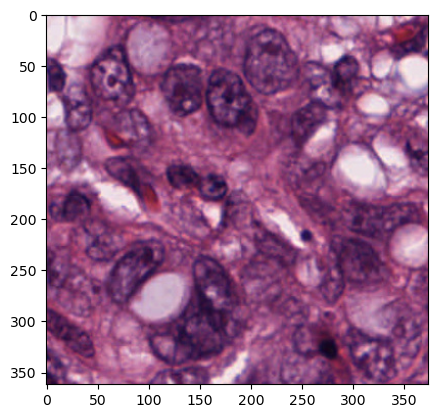

In [168]:
im_files = get_files(im_dir)
img_array = get_im_data(im_dir, im_files, 0)
print(img_array.shape)
plt.imshow(img_array)
plt.show()

In [169]:
def crop_img(image, xmin, ymin, xmax, ymax):
    return image[ymin:ymax, xmin:xmax]

def get_xy(csv_df,idx):
    return csv_df[['coords_x', 'xmin', 'xmax', 'ymin', 'ymax', 'coords_y']].iloc[idx].to_dict()

def cell_mask(img, x_cord, y_cord):
    if len(x_cord) != len(y_cord):
        raise ValueError("Length of x_cord and y_cord must be equal")
    
def get_nuc(img, csv, idx):
    num_nuc = len(csv)
    nucs_list = []
    for i in range(num_nuc):
        nuc = get_xy(csv, i)
        x =  np.array(nuc['coords_x'].split(",")).astype(int) 
        y =  np.array(nuc['coords_y'].split(",")).astype(int)
        im_h, im_w, im_c = img.shape
        mask = np.zeros((im_h, im_w, im_c), dtype=np.uint8)
        rr, cc = draw.polygon(y, x)
        mask[rr, cc,:] = 1
        del_back = np.multiply(mask, img)
        cropped_nuc = crop_img(del_back, nuc['xmin'], nuc['ymin'], nuc['xmax'], nuc['ymax'])
        nucs_list.append(cropped_nuc)
    return nucs_list


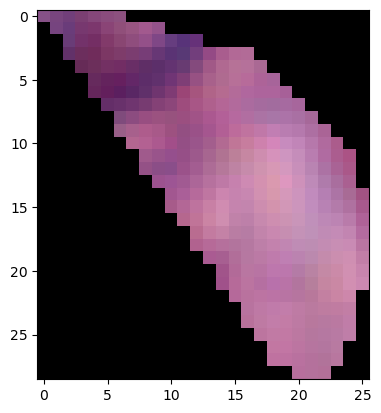

In [170]:
csv_df = get_csv_df(csv_dir, csv_files, 0)
first_nuc = get_xy(csv_df,0)
# first crop
x_points = np.array(first_nuc['coords_x'].split(",")).astype(int) 
y_points = np.array(first_nuc['coords_y'].split(",")).astype(int)
im_h, im_w = img_array.shape[:2]
mask = np.zeros((im_h, im_w,3), dtype=np.uint8)
rr, cc = draw.polygon(y_points, x_points)
mask[rr, cc,:] = 1
# plt.imshow(mask)
first_nuc_im = mask*img_array
# plt.imshow(first_nuc_im)
cropped_nuc = crop_img(first_nuc_im, first_nuc['xmin'], first_nuc['ymin'], first_nuc['xmax'], first_nuc['ymax'])
plt.imshow(cropped_nuc)

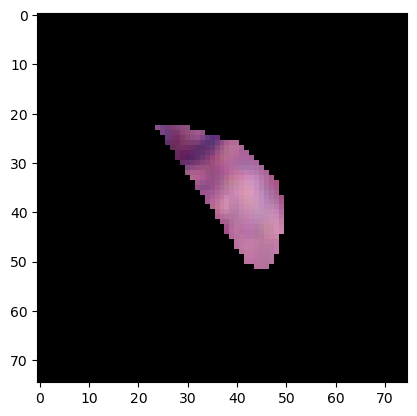

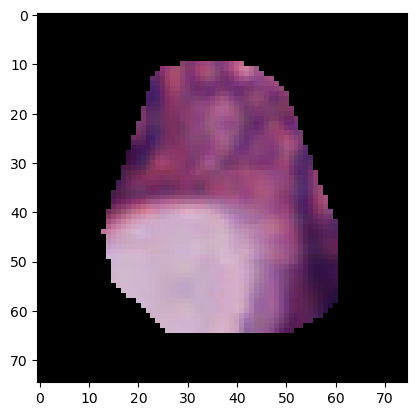

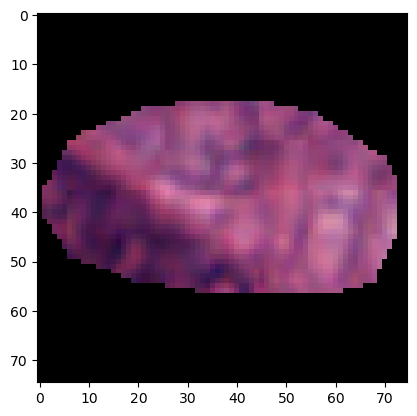

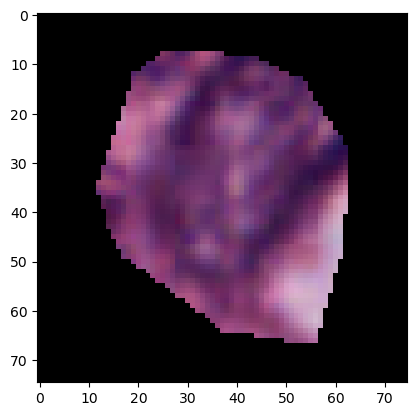

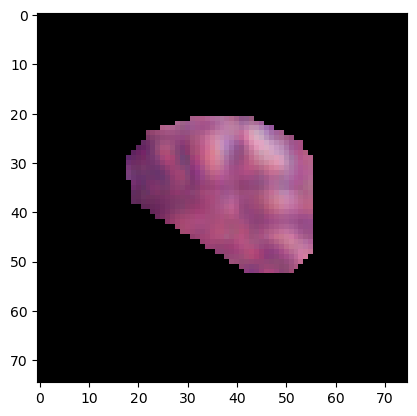

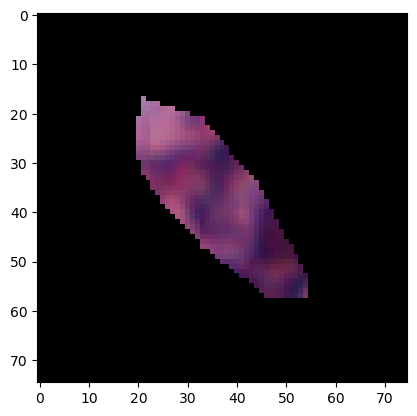

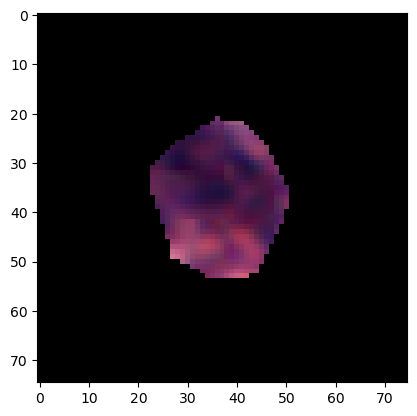

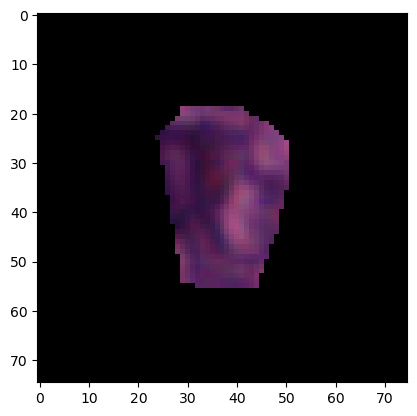

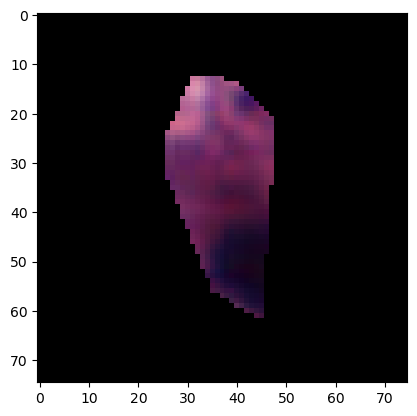

In [172]:
csv_df = get_csv_df(csv_dir, csv_files, 0)
img_array = get_im_data(im_dir, im_files, 0)
img_array = get_nuc(img_array, csv_df, 0)
for ims in img_array:
    # print(ims[ims!=0].shape)
    # avg_back = np.array(np.mean(ims[:,:,][ims!=0], axis=(0,1)),,)
    blank_mask = np.zeros((75, 75, 3))
    center_height = (blank_mask.shape[0] - ims.shape[0]) // 2
    center_width = (blank_mask.shape[1] - ims.shape[1]) // 2
    blank_mask[center_height:center_height + ims.shape[0], center_width:center_width + ims.shape[1], :] = ims
    # plt.imshow(ims)
    plt.imshow(blank_mask)
    plt.show()

# Create Dataset

In [ ]:
csv_files = get_files(csv_dir)
im_files = get_files(im_dir)
len(csv_files), len(im_files)

(1337, 1339)

In [ ]:
matching_files = []
for csv in csv_files:
    for im in im_files:
        csv_d = os.path.splitext(csv)[0]
        im_d = os.path.splitext(im)[0]
        if csv_d == im_d:
            matching_files.append((csv,im))
print(len(matching_files))

1337


In [ ]:
matching_files[0]

('SP.3_#_E_#_TCGA-E2-A158-01Z-00-DX1_id-5e83b15bddda5f83987d58dd_left-57092_top-27151_bottom-27425_right-57362.csv',
 'SP.3_#_E_#_TCGA-E2-A158-01Z-00-DX1_id-5e83b15bddda5f83987d58dd_left-57092_top-27151_bottom-27425_right-57362.png')

(9, 11)


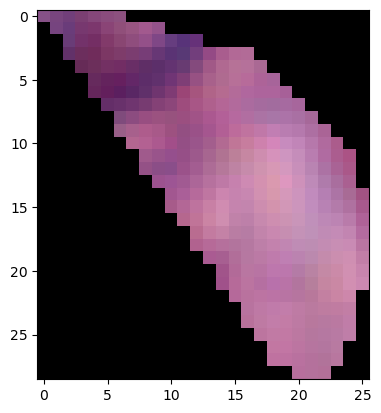

raw_classification      lymphocyte
main_classification     lymphocyte
super_classification          sTIL
Name: 0, dtype: object


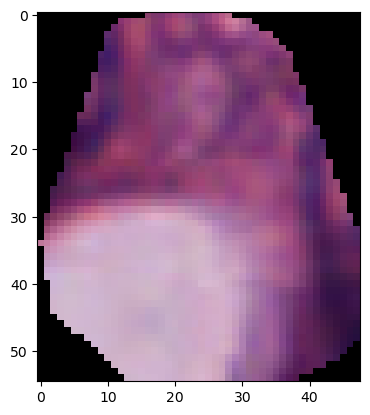

raw_classification                 tumor
main_classification     tumor_nonMitotic
super_classification           tumor_any
Name: 1, dtype: object


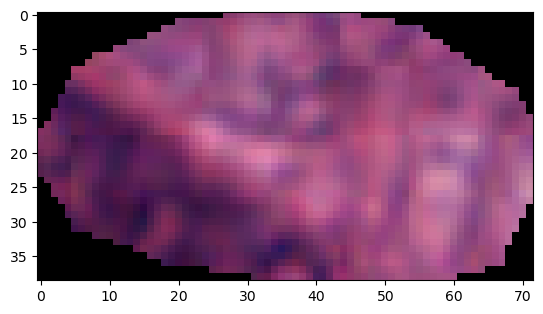

raw_classification                 tumor
main_classification     tumor_nonMitotic
super_classification           tumor_any
Name: 2, dtype: object


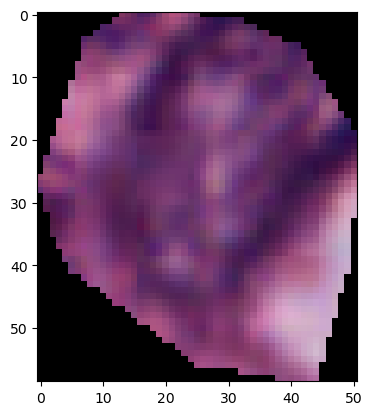

raw_classification                 tumor
main_classification     tumor_nonMitotic
super_classification           tumor_any
Name: 3, dtype: object
(50, 11)
(21, 11)


IndexError: index 347 is out of bounds for axis 0 with size 325

In [ ]:
csv_dir = "../DATASET/csv"
im_dir = "../DATASET/rgb"
csv_files = get_files(csv_dir)
im_files = get_files(im_dir)

final_df = pd.DataFrame()
iters = 0
for i, files in enumerate(matching_files):
    csv_df = get_csv_df(csv_dir, csv_files, i)
    print(csv_df.shape)
    img_files = get_im_data(im_dir, im_files, i)
    nucs = get_nuc(img_files, csv_df, i)
    for j, nuc in enumerate(nucs):
        label = csv_df[['raw_classification', "main_classification",	'super_classification']].iloc[j,:].to_numpy()
        label_df = csv_df[['raw_classification', "main_classification",	'super_classification']].iloc[j,:]
        if 'unlabeled' in label or 'AMBIGUOUS' in label:
            break
        plt.imshow(nuc)
        plt.show()
        print(label_df)
        iters+=1
    if iters == 1000:
        print(iters)
        break 